# Modelling SVEIR epidemic spread with continuous populations

A new iteration after I was running into too many problems with the last one.

In [1]:
#Import necessary libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numpy import genfromtxt
import matplotlib.image as mpimg
import pandas as pd
import scipy
import time

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [4]:
waloc = pd.read_csv('/Users/Yuval/Desktop/Thesis/all-wa-pos.csv')#use this for all 297 towns
waloc = waloc.loc[waloc['Population'] >0]
# When doing big towns
waloc = waloc[:58]

# When ignoring sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Yanchep') & (waloc['City / Town'] != 'Bullsbrook') &
                  (waloc['City / Town'] != 'Mundijong') & (waloc['City / Town'] != 'Serpentine') &
                 (waloc['City / Town'] != 'Two Rocks') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring rural satellites
waloc = waloc.loc[(waloc['City / Town'] != 'Pinjarra') & (waloc['City / Town'] != 'Drummond Cove') &
                  (waloc['City / Town'] != 'Bridgetown') & (waloc['City / Town'] != 'Binningup') &
                 (waloc['City / Town'] != 'Dampier') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

In [5]:
# Create a network from a weekly dataset
my_data = genfromtxt('/Volumes/HardDrive/New_Workflow/symm_stoc_48/Town_Flow_20200322_20200328.csv',delimiter = ',')
A = nx.from_numpy_matrix(my_data)
A = nx.DiGraph(A)

# Use this network to label all the nodes, matching their index to the town name
towns = list(waloc['City / Town'])
labeldict = {}
for node in list(A.nodes()):
    labeldict[node] = towns[node]

In [6]:
# Read in all weekly adjacnecy matrices, assigning each entry to a dictionary.
st = os.listdir("/Volumes/HardDrive/New_Workflow/symm_stoc_48")

stoch = []
for i in st:
    if '._' not in i:
        stoch.append(i)

In [7]:
d = {}
for i in range(len(stoch)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/symm_stoc_48/"+stoch[i], header = None, sep =',')

In [8]:
def sveir(params,x,popn,changes,effic):
    xdot = list(np.zeros(7))
    eff1, eff2, eff3 = effic[0], effic[1], effic[2]
    xdot[0] = -params[0]*x[0]*x[5]/popn - changes[0] # Susceptible
    xdot[1] = -eff1*params[0]*x[1]*x[5]/popn +changes[0] - changes[1] #One Dose
    xdot[2] = -eff2*params[0]*x[2]*x[5]/popn + changes[1] - changes[2] # Two doses
    xdot[3] = -eff3*params[0]*x[3]*x[5]/popn + changes[2] + 1/84*x[6]
    xdot[4] = params[0]*x[0]*x[5]/popn + eff1*params[0]*x[1]*x[5]/popn + eff2*params[0]*x[2]*x[5]/popn + eff3*params[0]*x[3]*x[5]/popn - params[1]*x[4] #Exposed
    xdot[5] = params[1]*x[4] - params[2]*x[5] # Infected
    xdot[6] = params[2]*x[5] - 1/84*x[6] # Removed
    
    infected_daily = params[1]*x[4]
    
    return xdot, infected_daily

In [9]:
def dynamics(x_init, num, steps, params, popn, changes):
    
    x = x_init
    y = []
    changes = [0,0,0]
    
    town_infs = []
    for i in range(num):
        
        xy = []
        
        infected_daily = []
        for t in range(steps):
            if t == 0:
                xdot, infs = sveir(params, x[i],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[x[i],xdot])])
                infected_daily.append(infs)
            else:
                xdot, infs = sveir(params, xy[-1],popn[i], changes, effic)
                xdot = [n/steps for n in xdot]
                xy.append([sum(n) for n in zip(*[xy[-1],xdot])])
                infected_daily.append(infs)
                
        town_infs.append(sum(infected_daily)/steps)
        y.append(xy[-1])
    
    return y, town_infs

In [10]:
def movement(x_init, day, num_towns,popn):
        
    week = int(day//7)+70

    flow = d[str(week)].copy()*C
    
    move = []
    
    for i in range(num_towns):
        incoming = [0]*7
        outgoing = [0]*7
        for j in range(num_towns):
            for k in range(7):
                # Get the movement between the two towns
                incoming[k] += flow[j][i] *1/7 *x_init[j][k]/popn[j]
                outgoing[k] += flow[i][j] *1/7 *x_init[i][k]/popn[i]
        move.append([incoming,outgoing])
    
    return move

In [11]:
## WA Data Processing
wa_data = pd.read_csv('/Users/Yuval/Desktop/Thesis/wa_health.csv')

# Daily cases
wa_totals = list(wa_data.iloc[0])[1:]
wa_totals = [i - 1134 for i in wa_totals]
wa_infs = [0]
for i in range(1,len(wa_totals)):
    wa_infs.append(wa_totals[i]-wa_totals[i-1])
    
    
# WA's population is 2491996 people over 5
# https://www.health.gov.au/sites/default/files/documents/2022/02/covid-19-vaccine-rollout-update-1-february-2022.pdf
# There are 377018 people between 5-15, so normalise the third dose based on that

first = list(wa_data.loc[wa_data['Source'] == 'COVID-live First Doses 5+'].iloc[0])[1:]
first_change = []
for f in range(len(first)-1):
    first_change.append(first[f+1] - first[f])

second = list(wa_data.loc[wa_data['Source'] == 'COVID-live Second Doses 5+'].iloc[0])[1:]
second_change = []
for f in range(len(second)-1):
    second_change.append(second[f+1] - second[f])

third = list(wa_data.loc[wa_data['Source'] == 'COVID-live Booster Doses 16+'].iloc[0])[1:]
third = [round(i*2491996/(2491996-377018)) for i in third]
third_change = []
for f in range(len(third)-1):
    third_change.append(third[f+1] - third[f])

uptakes = [first_change, second_change, third_change]


In [12]:
# Make it so there are no negatives (there were only two when I checked)
for i in range(len(uptakes)):
    for j in range(len(uptakes[i])):
        if uptakes[i][j] < 0:
            print(i,j)
            uptakes[i][j] = 0

0 103
0 110


In [13]:
# Find initial values

init_first_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live First Doses 5+ (%)'].iloc[0])[1]
init_second_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live Second Doses 5+ (%)'].iloc[0])[1]
init_third_dose = list(wa_data.loc[wa_data['Source'] == 'COVID-live Booster Doses 16+ (%)'].iloc[0])[1]

init1 = init_first_dose- init_second_dose-init_third_dose
init2 = init_second_dose - init_third_dose
init3 = init_third_dose

In [14]:
# Number of towns we'll be investigating in this run (max = 53 for bigs only, 58 with sattelite towns,
# 297 for all towns)
popn = list(waloc['Population'])

num = 48
one = 1/popn[0]
#x_init = [0.02,0.02,0.85,0.11-(5*infect),4*infect,infect,0]
x_init = [1-init1 - init2 - init3 - 5*one, init1 - 5*one, init2 - 5*one, init3 - 5*one, 16*one, 4*one,0]

# Go with 0 infections elsewhere
y_init = [1-init1 - init2 - init3, init1, init2, init3, 0, 0,0]
init = [x_init]
for i in range(num-1):
    init.append(y_init)

## Multiply it by population in each town.
popn = list(waloc['Population'])
#popn[0] = 1770000

town_init = []
for i in range(num):
    item = init[i]
    new_item = []
    for j in range(len(item)):
        new_item.append(item[j] * popn [i])
    town_init.append(new_item)  
    
    
days = 112
steps = 5

L = 2.5
a1, a2,a3, D = 0.97558821, 0.29647689, 0.54174642, 4.02110478
effic = [1-0.293, 1-0.128, 1-0.58]

C= 9*10**9

In [19]:
params = [a1, 1/L, 1/D]

model = [town_init]

x_init = town_init

day_infs = [0]

for day in range(days):
    print(day)

    if day < 12:
        params[0] = a1
    elif (day>= 12) and (day < 63):
        params[0] = a2
    elif day >=63:
        params[0] = a3
        
    changes = [uptakes[0][day],uptakes[1][day], uptakes[2][day]]
        
    dyn, town_infs = dynamics(model[-1], num, steps, params, popn, changes)
    
    day_infs.append(sum(town_infs) + day_infs[-1])
    
    mov = movement(dyn, day, num, popn)
    
    dynmov = []
    for i in range(len(dyn)):
        dynmov.append([dyn[i][d] + mov[i][0][d] - mov[i][1][d] for d in range(len(dyn[i]))])

    
    model.append(dynmov)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


IndexError: list index out of range

In [20]:
for i in model:
    for j in i:
        for k in j:
            if k < 0:
                print('Problem')

In [30]:
for i in model:
    s = 0
    for j in i:
        s+= sum(j)
    print(s)

2300244.0
2300244.0000000005
2300244.000000001
2300244.000000001
2300244.000000001
2300244.000000001
2300244.000000001
2300244.0
2300244.0
2300244.0
2300244.0000000005
2300244.0000000005
2300244.0000000005
2300244.0000000005
2300244.0000000005
2300244.0
2300244.0
2300244.0
2300244.0
2300244.0
2300244.0
2300244.0
2300243.9999999995
2300243.9999999995
2300243.9999999995
2300243.9999999995
2300243.9999999995
2300243.999999999
2300244.0
2300243.9999999995
2300243.9999999995
2300243.999999999
2300243.9999999995
2300243.999999999
2300243.9999999995
2300243.9999999995
2300244.0
2300243.9999999995
2300243.9999999995
2300244.0
2300244.0
2300243.9999999995
2300243.9999999995
2300243.9999999995
2300243.9999999995
2300243.999999999
2300243.999999999
2300243.9999999995
2300243.9999999995
2300243.9999999995
2300244.0
2300244.0
2300244.0
2300244.0
2300244.0
2300244.0
2300244.0
2300243.9999999995
2300243.999999999
2300243.999999999
2300243.999999999
2300243.9999999995
2300243.999999999
2300243.9999999

Text(0.5, 0, 'Days from outbreak')

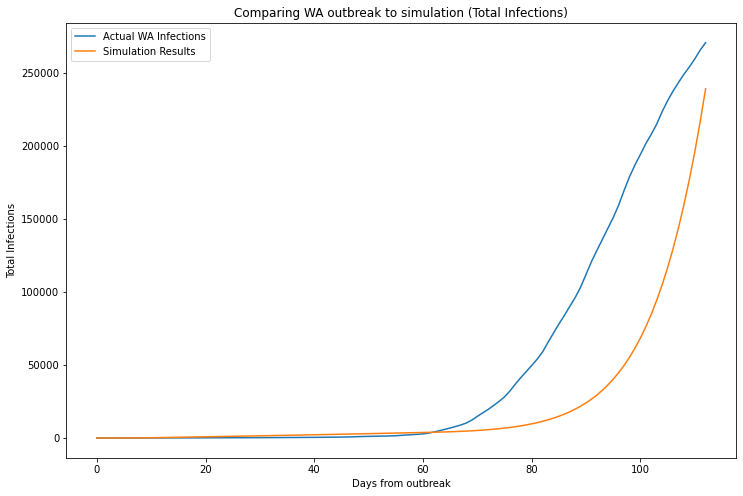

In [21]:
plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Total Infections)')
plt.plot(wa_totals, label = 'Actual WA Infections')
plt.plot(day_infs, label = 'Simulation Results')
plt.legend()
plt.ylabel('Total Infections')
plt.xlabel('Days from outbreak')

Text(0.5, 0, 'Days from outbreak')

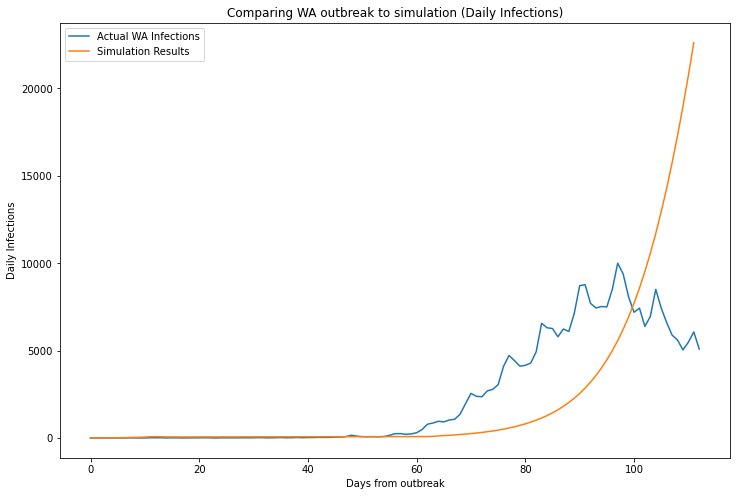

In [22]:
new_infs = [day_infs[i]-day_infs[i-1] for i in range(1,len(day_infs))]
plt.figure(figsize = (12,8))
plt.title('Comparing WA outbreak to simulation (Daily Infections)')
plt.plot(wa_infs, label = 'Actual WA Infections')
plt.plot(new_infs, label = 'Simulation Results')
plt.legend()
plt.ylabel('Daily Infections')
plt.xlabel('Days from outbreak')

In [23]:
compartments = ['Sus', 'V1', 'V2', 'V3', 'Exp', 'Inf', 'Rec']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


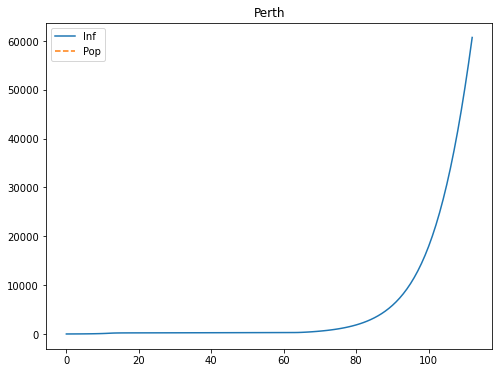

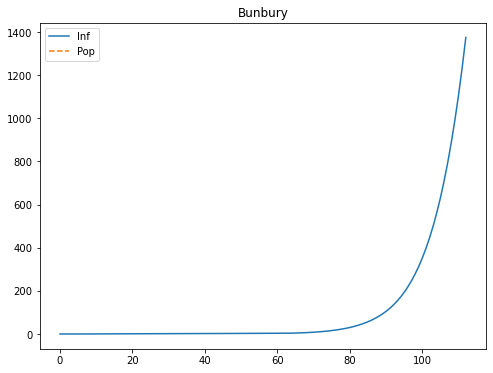

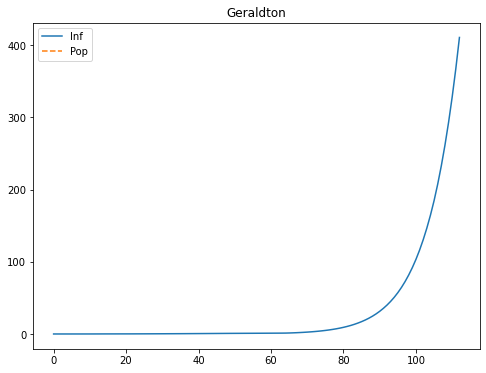

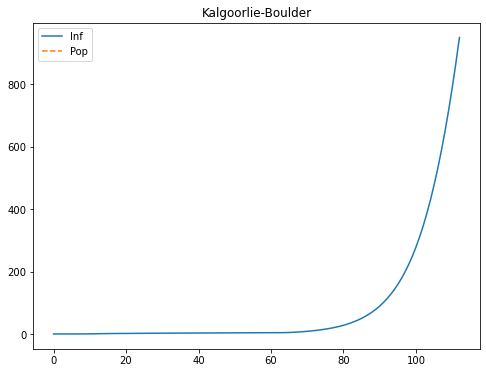

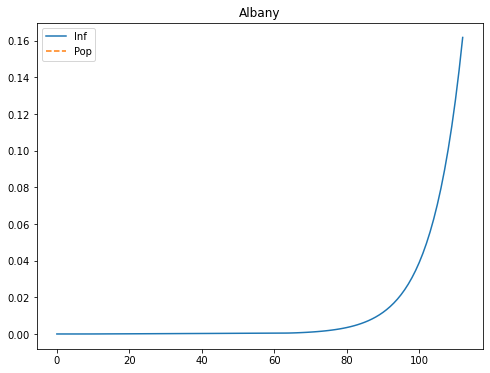

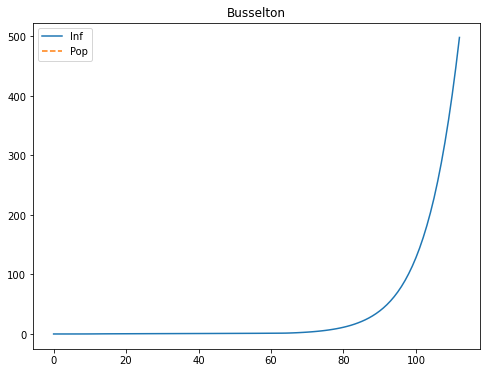

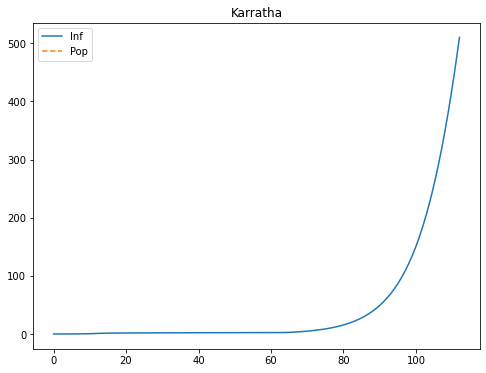

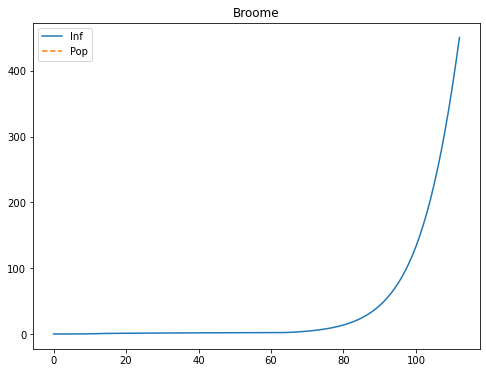

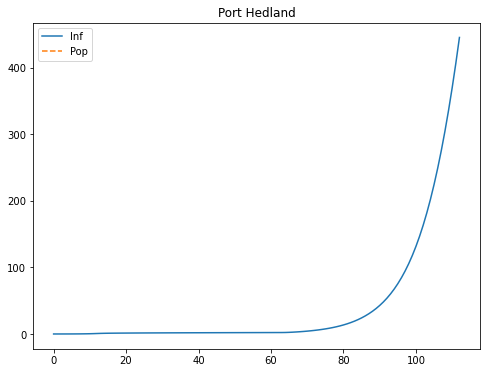

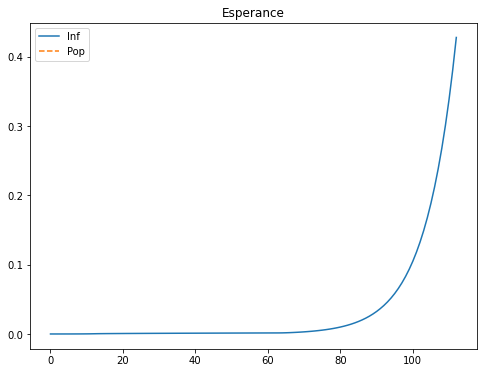

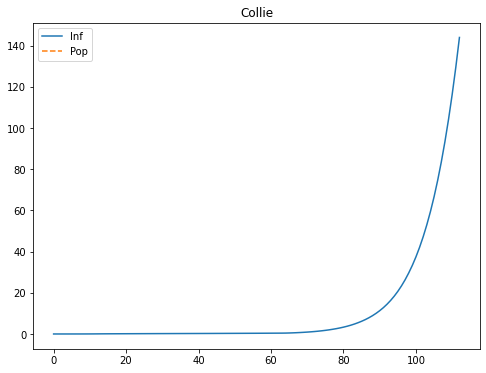

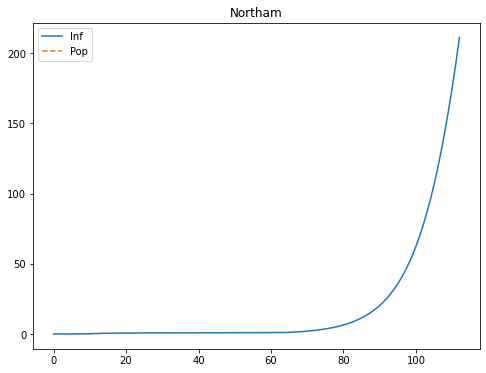

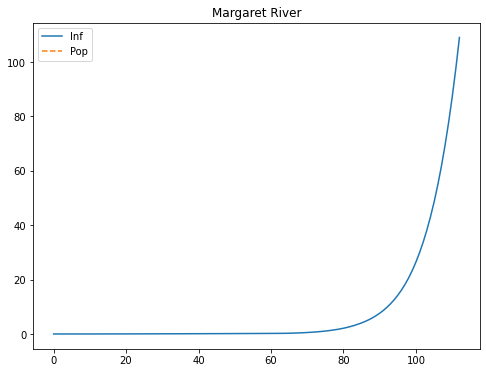

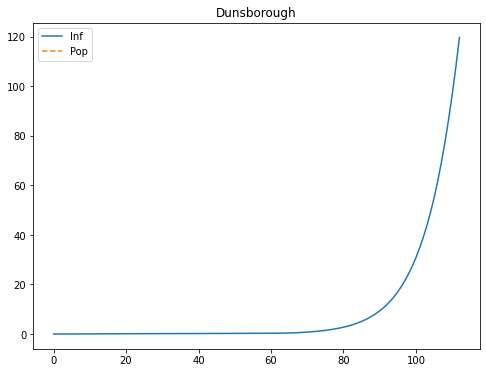

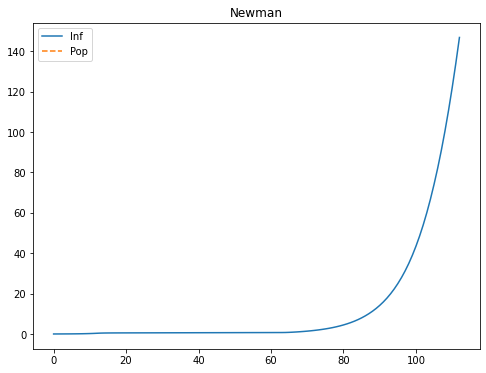

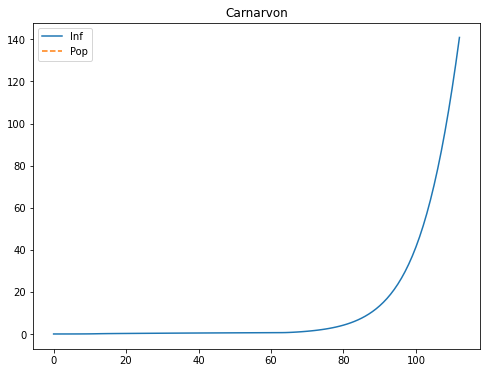

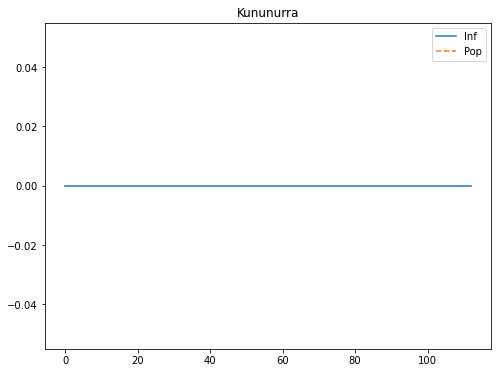

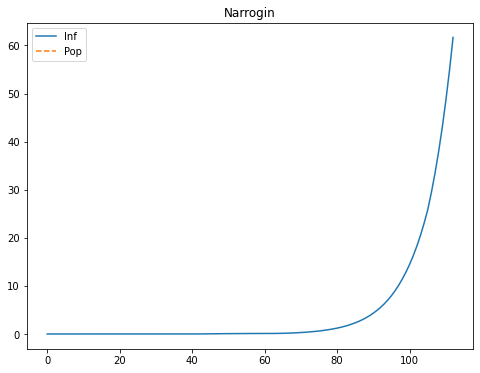

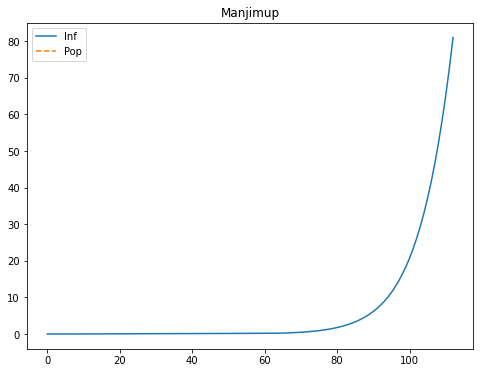

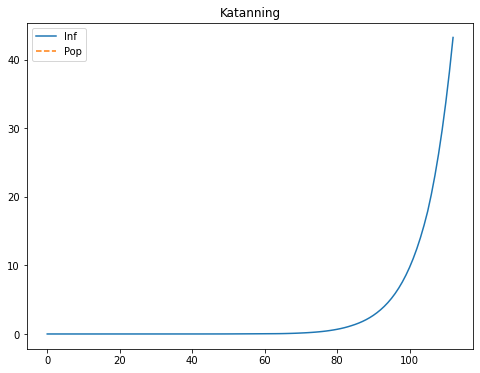

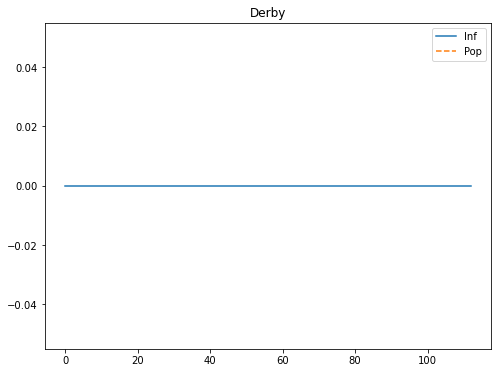

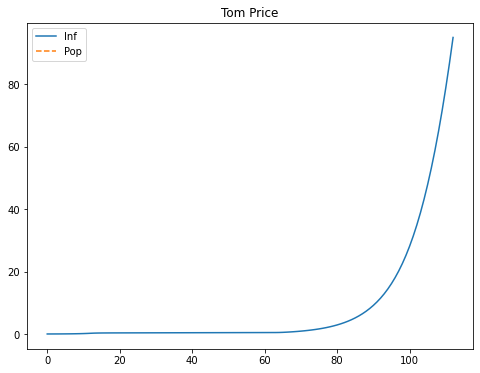

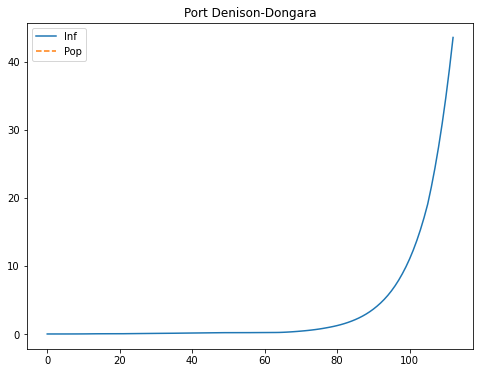

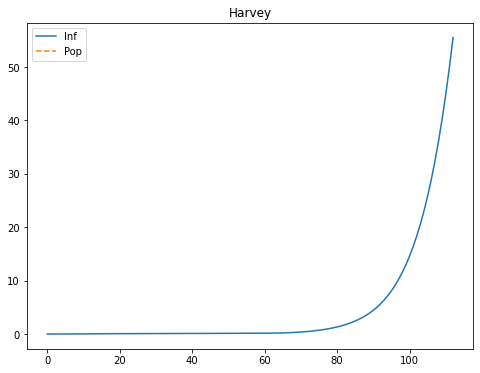

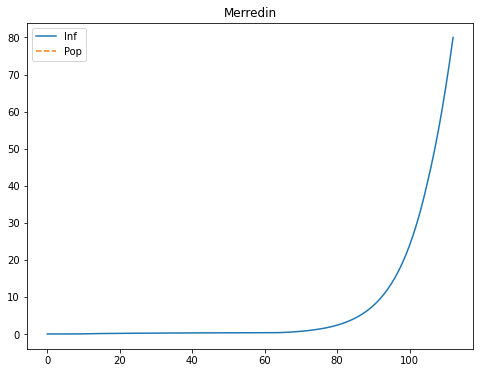

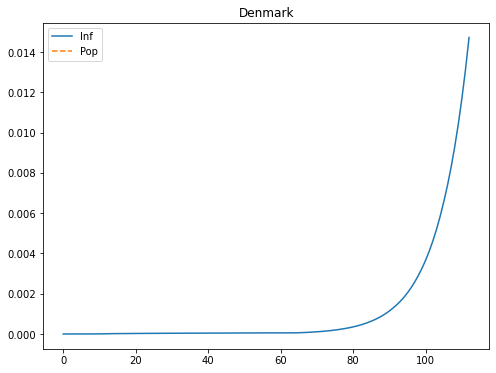

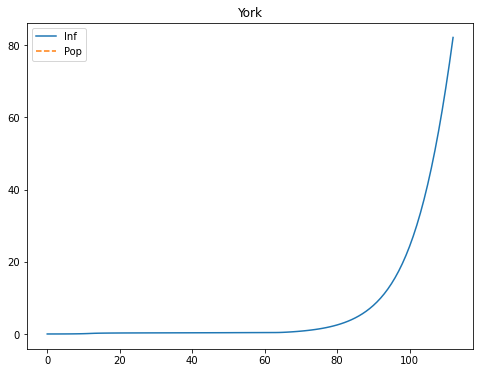

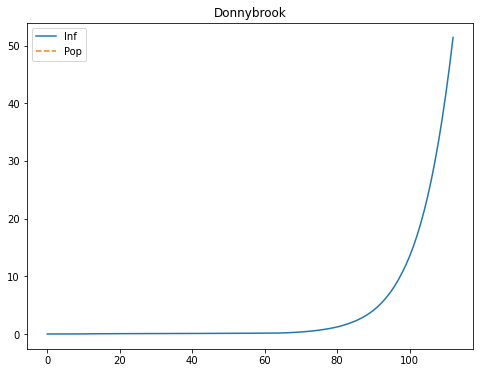

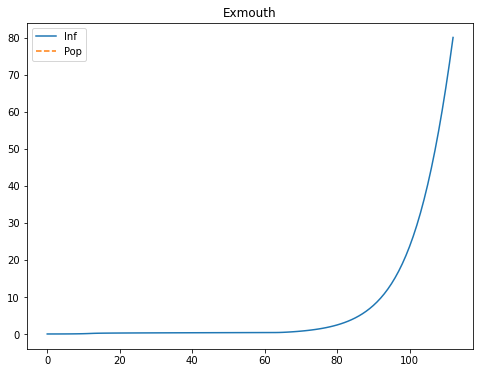

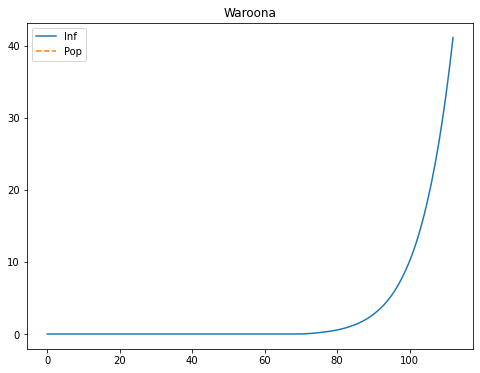

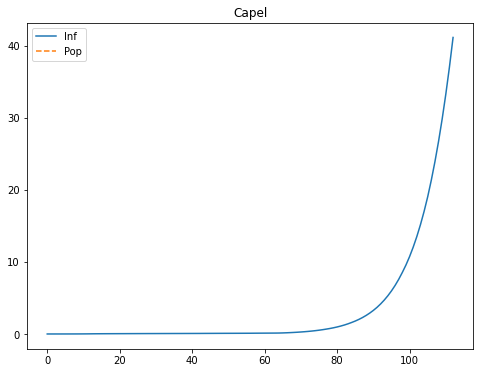

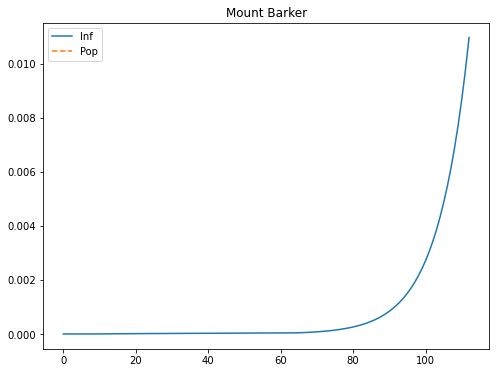

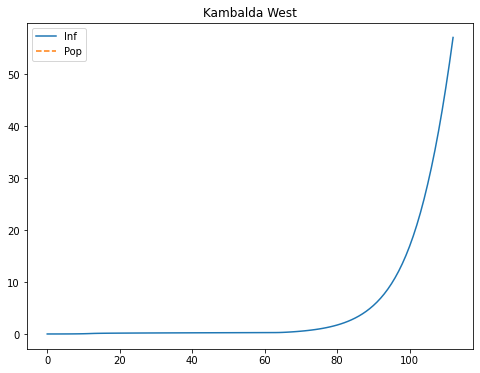

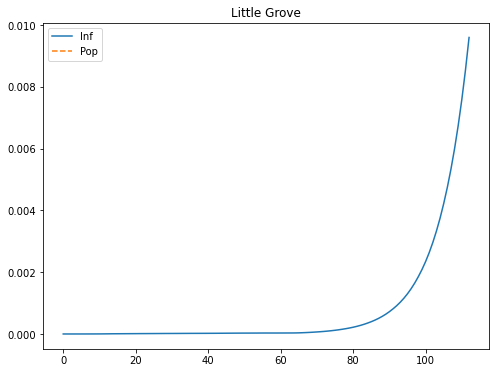

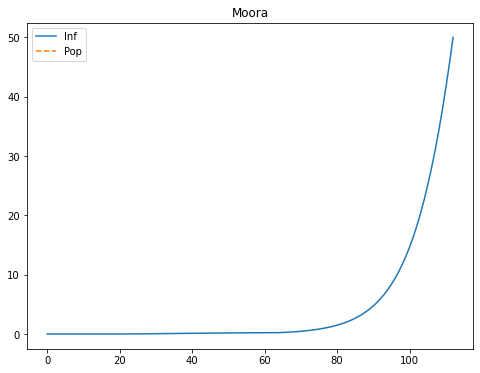

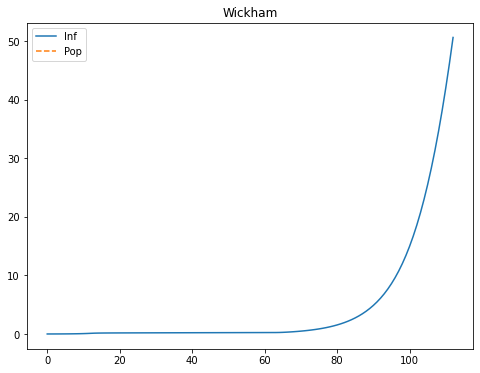

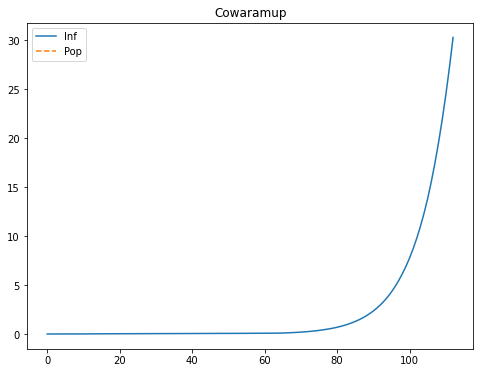

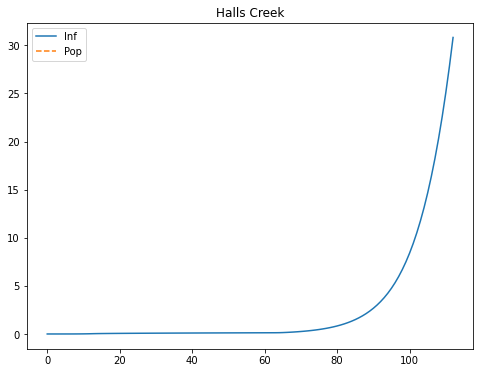

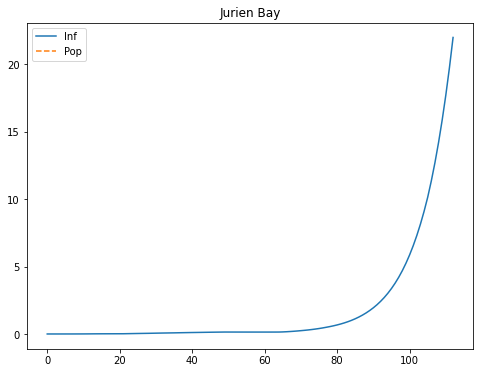

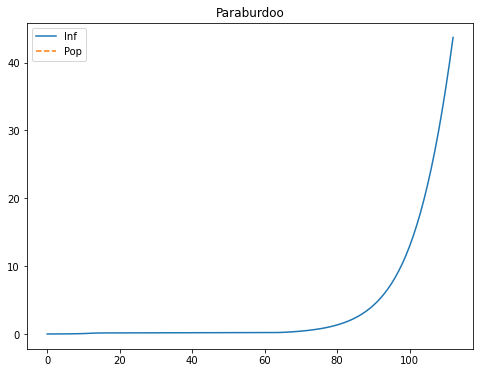

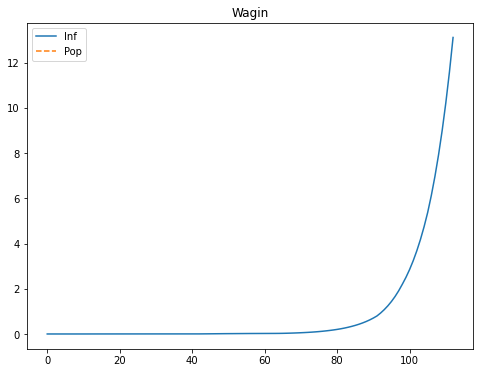

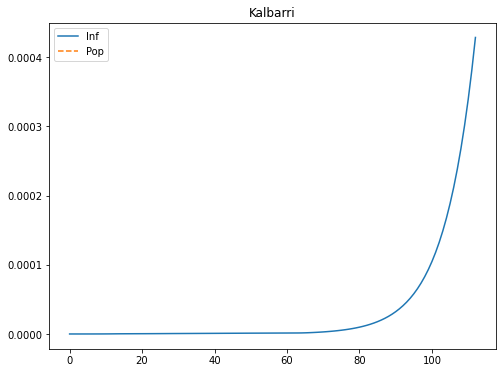

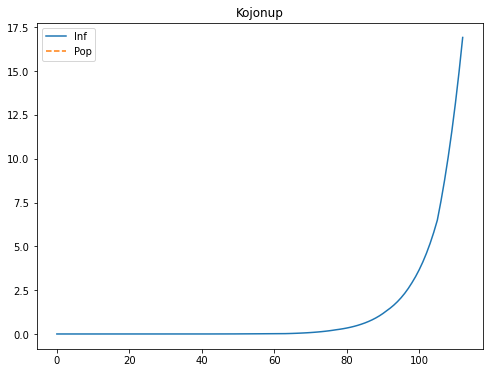

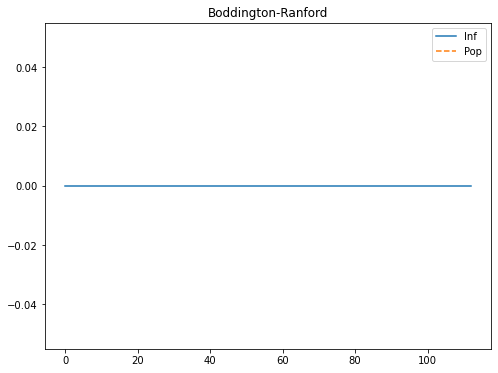

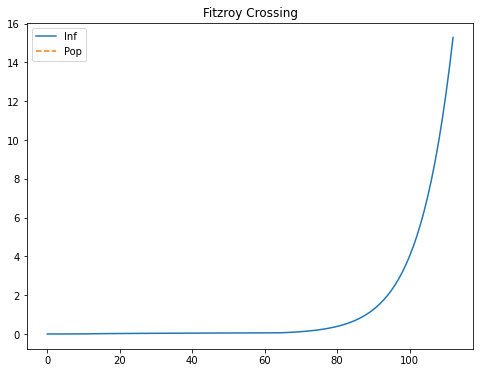

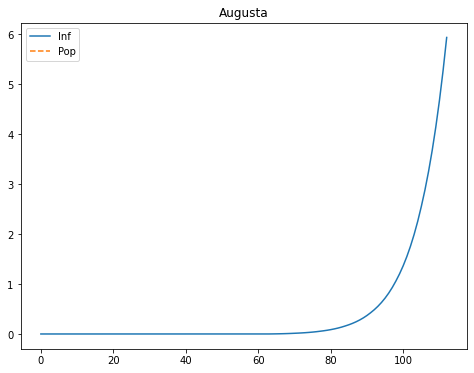

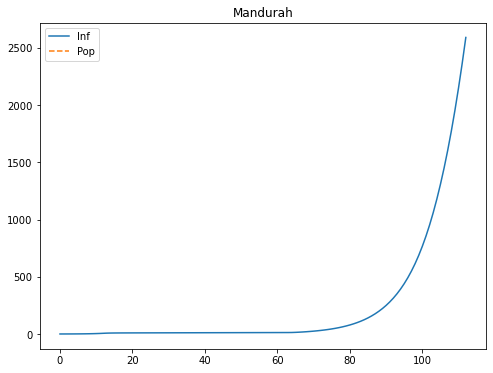

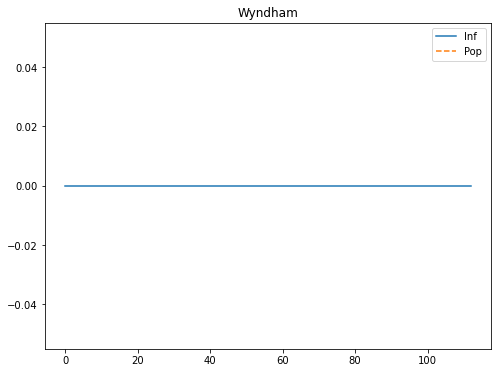

In [24]:
for town in range(num):
    plt.figure(figsize = (8,6))
    plt.title(towns[town])
    total_pop = []
    for k in range(8):
        #if k < 7:
        if k == 5:
            llist = []
            for day in range(days):
                llist.append(model[day][town][k])
            plt.plot(llist,label = compartments[k])
        #else:
        #    for day in range(days):
        #        total_pop.append(sum(model[day][town]))
    plt.plot(total_pop, linestyle = 'dashed', label = 'Pop')
    plt.legend()

In [114]:
# Just examine population for all towns for one sec

In [23]:
num = 53
C = 9*10**9

pop = [list(waloc['Population'])]
popn = list(waloc['Population'])

In [24]:
for i in range(97):
    
    flow = d[str(i)].copy()*C
    
    move = []
    
    temp_pop = []
    for j in range(num):
        moving = []
        for k in range(num):
                # Get the movement between the two towns
                moving.append(flow[k][j]- flow[j][k])
        temp_pop.append(sum(moving))
    
    pop.append([pop[-1][p]+temp_pop[p] for p in range(num)])

In [25]:
for item in pop:
    for i in range(len(item)):
        item[i] = item[i]/popn[i]

(0.0, 2.0)

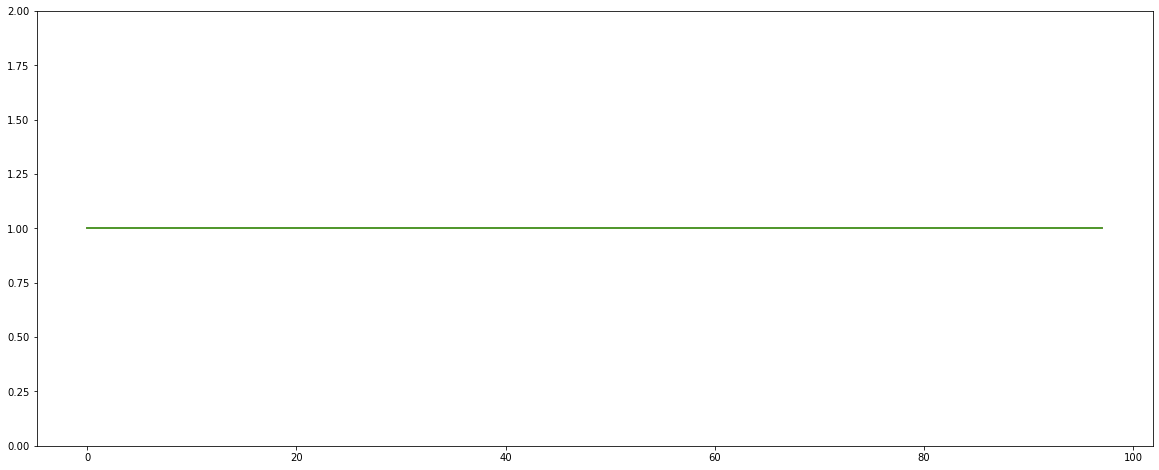

In [26]:
plt.figure(figsize = (20,8))
zipped = list(zip(*pop))
for i in range(len(zipped)):
    item = zipped[i]
    plt.plot(item, label = towns[i])
plt.ylim([0,2])
#plt.legend()

In [213]:
## Total flow for a town

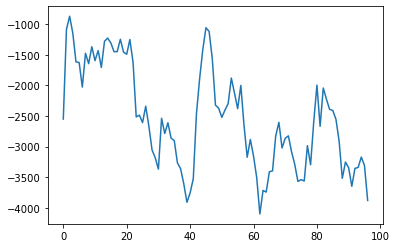

In [243]:
temp_pop = []
for i in range(97):
    
    flow = d[str(i)].copy()*C
    
    move = []
    j = 32
    moving = []
    for k in range(num):
        moving.append(flow[k][j]- flow[j][k])
    temp_pop.append(sum(moving))
    
    #pop.append([pop[-1][p]+temp_pop[p] for p in range(num)])
plt.plot(temp_pop)

In [244]:
popn[32]

2020

In [221]:
temp_pop

[-2675.071040093277]

In [233]:
## Total incoming vs total outgoing

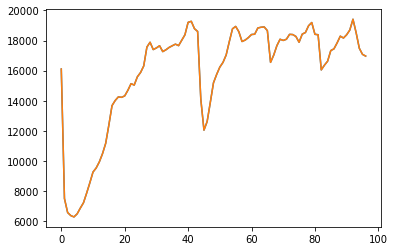

In [234]:
total_incoming = []
total_outgoing = []
for i in range(97):
    
    flow = d[str(i)].copy()*C
    
    temp_incoming = []
    temp_outgoing = []
    
    for j in range(num):
        incoming = []
        outgoing = []
        for k in range(num):
            incoming.append(flow[k][j])
            outgoing.append(flow[j][k])
        temp_incoming.append(sum(incoming))
        temp_outgoing.append(sum(outgoing))
    total_incoming.append(sum(temp_incoming))
    total_outgoing.append(sum(temp_outgoing))
    
    
    #pop.append([pop[-1][p]+temp_pop[p] for p in range(num)])
plt.plot(total_incoming)
plt.plot(total_outgoing)